# LPP mean analysis
### Time window: 600-1950 ms
In this script we conduct comparisons using linear mixed effects models for the purpose of comparing the late positive potential (LPP) response. The file leverages data that was generated with the `stats_TSN_eeg_prep.ipynb` script.

## Load necessary libraries
If any of these don't load, you'll need to install them. Assuming you installed Jupyter through Anaconda, you would do the following to install a package
`conda install -c r r-[pkgName]`
e.g., to install ggplot2 you would do:
`conda install -c r r-ggplot2`

In [1]:
R.home()

[1] "/opt/conda/lib/R"

In [2]:
library(ggplot2)
library(mgcv)
library(parallel)
library(plyr)
library(tidyr)
library(data.table)
library(viridis)
library(ggthemes)
library(nlme)

Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘mgcv’ was built under R version 4.0.5”
Loading required package: nlme

This is mgcv 1.8-36. For overview type 'help("mgcv-package")'.

Warning message:
“package ‘plyr’ was built under R version 4.0.5”
Warning message:
“package ‘viridis’ was built under R version 4.0.5”
Loading required package: viridisLite



## Set parameters for this analysis

In [3]:
CurTimeWin = '600-1950'
component = 'LPP'

topdir = getwd()
expt = 'TSN'
outdir = (paste(topdir,'/R-data/Stats_Output',sep=''))
dir.create(outdir, showWarnings = FALSE)
# Functions we'll use later
source(paste(topdir,'/NCIL_functions.R',sep=""))

# source(paste(topdir,'/romr.fnc.R',sep=""))


# num parallel processes for bam(). Should be less than the number of threads supported by your CPU
num_cores = 4

options("scipen"=100, "digits"=5)  # force decimal instead of scientific notation

In [4]:
subjects = c('04','05','06','07','08','09','10','11','13','14','15','16','17','18','19','20','21','22','23','24') #12 omitted

## Load Data

In [5]:
dat  <- {}
for(s in 1:length(subjects)) {
    infile <- paste(topdir, '/R-data/', subjects[s], '_', component, '_mean_', CurTimeWin, '.csv',sep="")
    print(infile)
    tmpdat <- read.csv(infile) 
    tmpdat$Subj <- as.factor(subjects[s])
    tmplong <- gather(tmpdat, channel, meanAmpl, Fp1:VEOG) 
    tmplong$channel = as.factor(tmplong$channel)
    dat  <- rbind(dat, tmplong)
    }

setwd(topdir)

[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/04_LPP_mean_600-1950.csv"
[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/05_LPP_mean_600-1950.csv"
[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/06_LPP_mean_600-1950.csv"
[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/07_LPP_mean_600-1950.csv"
[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/08_LPP_mean_600-1950.csv"
[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/09_LPP_mean_600-1950.csv"
[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/10_LPP_mean_600-1950.csv"
[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/11_LPP_mean_600-1950.csv"
[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/13_LPP_mean_600-1950.csv"
[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/14_LPP_mean_600-1950.csv"
[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/15_LPP_mean_600-1950.csv"
[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/16_LPP_mean_600-1950.csv"
[1] "/media/NCILscience/Conrad_TSN/Analysis/R-data/17_LPP_mean_600-1950.csv"

In [6]:
colnames(dat)[1] <- 'epoch'
colnames(dat)[2] <- 'condition'

In [7]:
head(dat) # displaying first 6? list continues for each subject, each channel and each epoch?

,epoch,condition,Subj,channel,meanAmpl
,<int>,<chr>,<fct>,<fct>,<dbl>
1,0,warn,04,Fp1,13.0898
2,1,onli,04,Fp1,-5.3165
3,2,neut,04,Fp1,-13.8536
4,3,nega,04,Fp1,5.3622
5,4,posi,04,Fp1,6.9607
6,5,neut,04,Fp1,-15.4856


In [8]:
summary(dat)

     epoch        condition              Subj          channel     
 Min.   :  0.0   Length:100558      24     : 5440   C3     : 2983  
 1st Qu.: 37.0   Class :character   08     : 5406   C4     : 2983  
 Median : 74.0   Mode  :character   06     : 5372   CP1    : 2983  
 Mean   : 74.4                      17     : 5338   CP2    : 2983  
 3rd Qu.:111.0                      20     : 5338   CP5    : 2983  
 Max.   :159.0                      14     : 5304   CP6    : 2983  
                                    (Other):68360   (Other):82660  
    meanAmpl      
 Min.   :-157.55  
 1st Qu.:  -3.50  
 Median :   1.53  
 Mean   :   2.59  
 3rd Qu.:   8.63  
 Max.   :  95.66  
                  

### Assign ROI labels to electrodes we will analyze, then drop remaining electrodes

Let's not use these in the initial analysis. We should keep the working code here just in case.

In [9]:
head(dat$channel)

[1] Fp1 Fp1 Fp1 Fp1 Fp1 Fp1
34 Levels: C3 C4 CP1 CP2 CP5 CP6 Cz F3 F4 F7 F8 FC1 FC2 FC5 FC6 Fp1 Fp2 ... VEOG

In [10]:
dat$ROI = 'NA' # which electrodes WILL we analyze? Should I focus just on the Pz/POz region?

dat$ROI<-rep('0',times=nrow(dat))

Back =  c('Cz', 'CP1', 'CP2','Pz') # CPz region
which(dat$channel%in%Back)->x
dat$ROI[x]<-"Back" 

dat$ROI <- factor(dat$ROI, levels = c("Back"))

# dat = droplevels(dat)
dat <- dat %>% drop_na(ROI)

In [11]:
str(dat)

'data.frame':	11932 obs. of  6 variables:
 $ epoch    : int  0 1 2 3 4 5 6 7 8 9 ...
 $ condition: chr  "warn" "onli" "neut" "nega" ...
 $ Subj     : Factor w/ 20 levels "04","05","06",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ channel  : Factor w/ 34 levels "C3","C4","CP1",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ meanAmpl : num  3.846 3.752 0.782 17.85 10.486 ...
 $ ROI      : Factor w/ 1 level "Back": 1 1 1 1 1 1 1 1 1 1 ...


In [12]:
summary(dat)

     epoch        condition              Subj         channel    
 Min.   :  0.0   Length:11932       24     : 640   CP1    :2983  
 1st Qu.: 37.0   Class :character   08     : 636   CP2    :2983  
 Median : 74.0   Mode  :character   06     : 632   Cz     :2983  
 Mean   : 74.4                      17     : 628   Pz     :2983  
 3rd Qu.:111.0                      20     : 628   C3     :   0  
 Max.   :159.0                      14     : 624   C4     :   0  
                                    (Other):8144   (Other):   0  
    meanAmpl        ROI       
 Min.   :-58.15   Back:11932  
 1st Qu.: -2.75               
 Median :  4.89               
 Mean   :  5.20               
 3rd Qu.: 12.65               
 Max.   : 87.83               
                              

## Create Random Effects Variables

Create variable coding the condition x Subj random effects. This serves to address any heteroscedasticity (unequal variance) across conditions, and remove uninteresting, subject-specific noise.

In [13]:
dat$ElectrodebySubj = as.factor(paste(as.character(dat$Subj)
                                , as.character(dat$channel),
                                 sep = "_"))


In [14]:
dat$ConditionbySubj = as.factor(paste(as.character(dat$Subj)
                                , as.character(dat$condition),
                                 sep = "_"))

## Run initial full model to identify and remove outliers

Now run the model

In [15]:
m0 <- bam(meanAmpl ~ condition 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

In [16]:
dat <- romr.fnc(m0, dat, trim=2.5)$data

m1 <- bam(meanAmpl ~ condition
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

n.removed = 245 
percent.removed = 2.0533 


#### Find and remove outliers, then update model


Method: fREML   Optimizer: perf newton
full convergence after 9 iterations.
Gradient range [-0.000000026984,0.000000025494]
(score 46835 & scale 149.3).
Hessian positive definite, eigenvalue range [9.1516,5963.5].
Model rank =  25 / 25 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

          k'  edf k-index p-value
s(Subj) 20.0 18.7      NA      NA


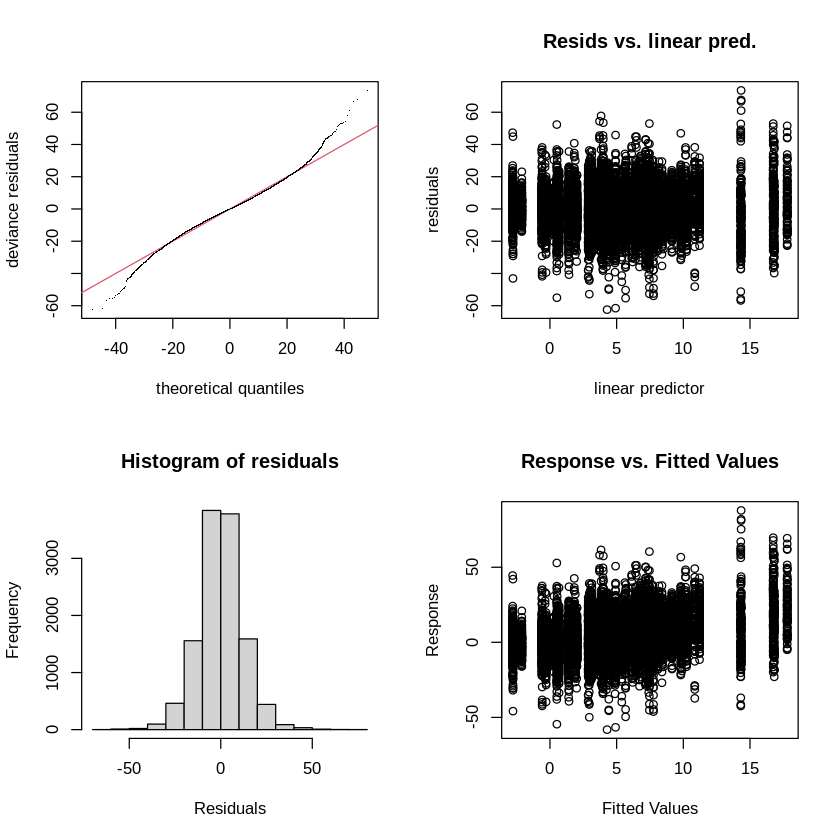

In [17]:
gam.check(m0)


Method: fREML   Optimizer: perf newton
full convergence after 9 iterations.
Gradient range [-0.000000042199,0.000000039947]
(score 44561 & scale 119.22).
Hessian positive definite, eigenvalue range [9.1627,5841].
Model rank =  25 / 25 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

          k'  edf k-index p-value
s(Subj) 20.0 18.7      NA      NA


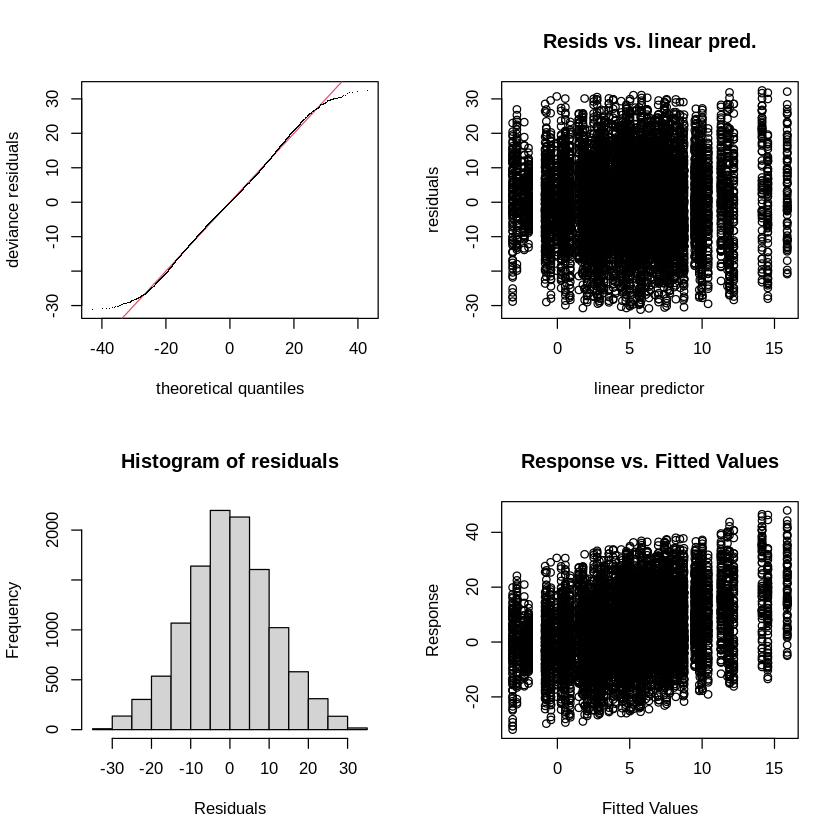

In [18]:
gam.check(m1)

## Compute cell means and CIs, and plot

In [19]:
dat$ROI = factor(dat$ROI, 
                 levels = c("Back")
                )

dat$condition = factor(dat$condition, 
                          levels = c("nega", "neut", "onli", "posi", "warn")
                       )

trialAvg = ddply(dat, 
                 .(Subj, condition),
                 summarize, 
                 Ampl = round(mean(meanAmpl), 3))


sumstats <- summarySEwithin(trialAvg, 
                            measurevar = "Ampl", 
                            withinvars = c("condition"),
                            idvar = "Subj")

In [20]:
sumstats$condition <- c("IAPS Negative", "IAPS Neutral", "Neutral Computer", "IAPS Positive", "Security Warning")

In [21]:
sumstats

condition,N,Ampl,Ampl_norm,sd,se,ci
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IAPS Negative,20,7.3256,7.3256,2.7284,0.61009,1.27694
IAPS Neutral,20,3.6374,3.6374,2.1315,0.47662,0.99758
Neutral Computer,20,3.3614,3.3614,3.2056,0.71679,1.50025
IAPS Positive,20,5.8061,5.8061,3.2388,0.72422,1.51581
Security Warning,20,6.0281,6.0281,2.7711,0.61964,1.29692


Saving 6.67 x 6.67 in image



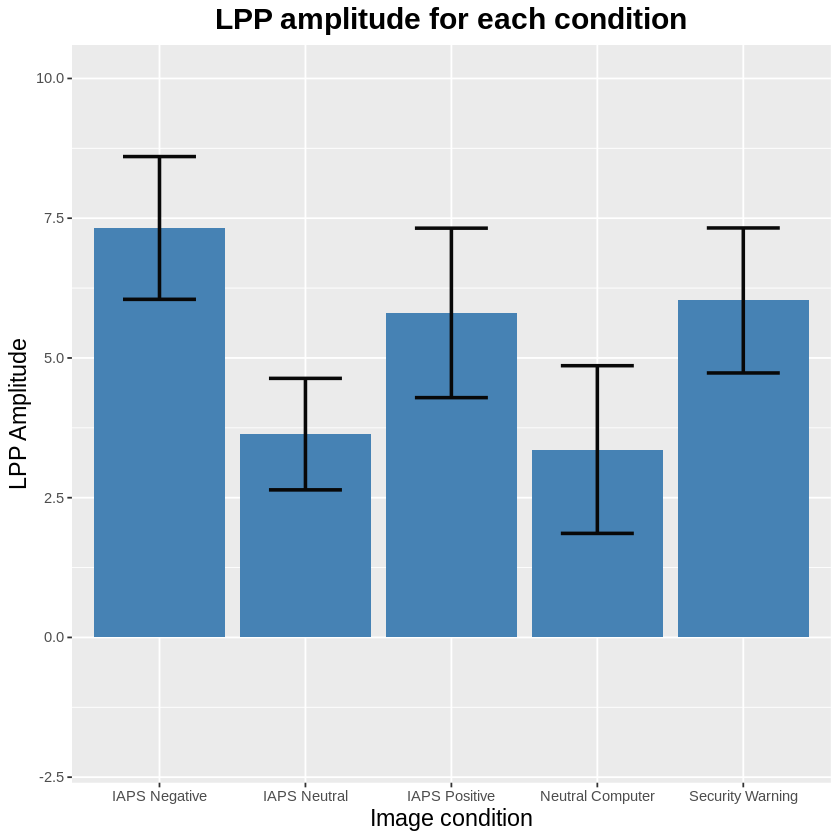

In [22]:
p <- ggplot(sumstats, aes(y=Ampl, x=condition)) + 
        geom_bar(position='dodge', stat='identity', fill='steelblue') +
        geom_errorbar(aes(ymin = Ampl - ci, ymax = Ampl + ci), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ylim(-2,10) + 
        ggtitle("LPP amplitude for each condition") + xlab("Image condition") + ylab("LPP Amplitude")

p + theme(
 plot.title = element_text(color="black", size=18, face="bold", hjust=0.5),
 axis.title.x = element_text(color="black", size=14),
 axis.title.y = element_text(color="black", size=14)

)

ggsave(filename='fig3_LPP.png', dpi=300)

# Effects Analysis
We will relevel teh data around the warning condition.

In [23]:
dat$condition <- relevel(dat$condition, 'warn')

In [24]:
cl <- makeCluster(num_cores)

mod <- bam(meanAmpl ~ condition
           + s(Subj, bs="re") 
           + s(ElectrodebySubj, bs="re") 
           + s(ConditionbySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

In [25]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
meanAmpl ~ condition + s(Subj, bs = "re") + s(ElectrodebySubj, 
    bs = "re") + s(ConditionbySubj, bs = "re")

Parametric coefficients:
              Estimate Std. Error t value     Pr(>|t|)    
(Intercept)      6.031      1.001    6.03 0.0000000017 ***
conditionnega    1.299      0.890    1.46       0.1445    
conditionneut   -2.390      0.890   -2.69       0.0073 ** 
conditiononli   -2.666      0.889   -3.00       0.0027 ** 
conditionposi   -0.260      0.890   -0.29       0.7701    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                    edf Ref.df      F             p-value    
s(Subj)            16.3     19 458.99 <0.0000000000000002 ***
s(ElectrodebySubj) 40.7     79   2.38              0.0088 ** 
s(ConditionbySubj) 68.6     95  11.55              0.1766    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.149   Devianc